In [1]:
import os
import sys
import math
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
def data_retrieval(sourcefile, metadata, pt_id):

	'''
	This function reads data for a single patient from a master spreadsheet with amplicon data for all plates/patients.
	Input is the sourcefile with the readcounts (allele_counts_anon), and a metadata file which contains cell type for each plate (Amplicon_metadata_fixed_anon.xlsx).
	The function returns a dataframe containing just the data for the specified patient, ready to merge with index data and then plot.
	'''

	df = pd.read_csv(sourcefile, header = [0,1,2], index_col = 0, sep='\t')
	df = df.stack([0,1,2])
	df = df.reorder_levels([1,0,2,3])
	df = df.to_frame()  #puts everything back in a dataframe
	df.columns = ['Reads']
	df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
	df['Well'] = df.index.get_level_values(1)
	df['Amplicon'] = df.index.get_level_values(2)
	df['Genotype'] = df.index.get_level_values(3)
	df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
	df = df.drop(columns = ['one', 'two'])

	#Import information about plate cell type and patient
	key = pd.read_excel(metadata, sheet_name = 'PlateID') #should this be an input? also in next fucntion
	key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
	key.rename(columns = {'Comments2':'Plate'}, inplace = True)
	key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

	#Make a dictionary to associate plates with patients and plate with cell type
	plate_pt_dict = dict(zip(key.Plate, key.Patient))
	plate_cell_dict = dict(zip(key.Plate, key.Celltype))

	#Now just look at data from selected patient, and apply filters to identify cells with enough reads/amplicon
	pt_allele_plate = df.loc[df['Patient'].isin([pt_id])] 
	pt_allele_plate = pt_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
	pt_allele_plate['Cell_type'] = pt_allele_plate['Plate'].replace(plate_cell_dict)
	pt_allele_plate['Plate_Well'] = pt_allele_plate['Plate'].astype(str) + '_' + pt_allele_plate['Well'].astype(str)

	return pt_allele_plate

In [3]:
def calc_scVAF(data, pt_init, reads):
    
    '''
    This function takes amplicon read counts for mt and wt and calculates the proportion of mutated alleles in each cell that meets the specified read count.
    Not sure this is the best method though, the second function calc_scVAF_binary_per_cell() is aligned to method for calling haps
    '''
    
    cond = pt_init
    print(cond)
    
    if cond == 'JP001':  #cols is the columns actually being used, can be easily tweaked
        #cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a']
        cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
        allcols = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
    elif cond == 'PD7153':
        cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
        allcols = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
    elif cond == 'PD7151': 
        cols = ['PD7151_TET2a', 'PD7151_TET2b']
        allcols = ['PD7151_TET2a', 'PD7151_TET2b']
        
    else:
        print('Enter JP001,  PD7153, or PD7151 as pt_id')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    df['Sort_cell_type'] = df['Plate'].replace(plate_cell_dict) #df now contains cell type as well
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    dfcells = df['Sort_cell_type'].drop_duplicates().to_list()
    print(f'Cells with {reads} reads  = ', len(wells))

    for dfc in dfcells:
        print(dfc, (df.loc[df['Sort_cell_type'].isin([dfc])]).shape[0])

    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']
    

    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])
    df2 = df2.unstack(2)
    df2.columns = cols


    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = ['Plate', 'Well'])
    
    rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34'}
    df2['Sort_cell_type'].replace(rename, inplace = True)
    df2.sort_values(by=['Sort_cell_type'], inplace = True)
    
    x = df2.copy().groupby(by = 'Sort_cell_type').mean()
    x = x.unstack().to_frame()
    x['celltype'] = x.index.get_level_values(1)
    x['Amplicon'] = x.index.get_level_values(0)
    co = ['VAF', 'sort_celltype', 'Amplicon']
    x.columns = co
    x.sort_values(by=['sort_celltype'], inplace = True)
    
    all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
    colors = sns.color_palette('husl', n_colors = len(all_amps))
    allVAFcols = dict(zip(all_amps, colors))

    fig, ax = plt.subplots(figsize = (2.5,4))
    sns.scatterplot(x = 'sort_celltype', y = 'VAF', data = x, s = 100,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax)
    ax.legend(loc = 'upper left', bbox_to_anchor = [1,1], title = 'scVAFs by read frequency')
    ax.set_ylim(0,0.6)
    ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.margins(x=0.1)   
    
    return x

def calc_scVAF_binary_per_cell(data, pt_init, reads, cutoff):
    
    '''
    This function takes amplicon read counts for mt and wt and calculates whether a given cell does (1) or does not (0) contain a mutant allele, based on the desired read count and cutoff values.
    '''
    
    cond = pt_init
    print(cond)
    
    if cond == 'JP001':  #cols is the columns actually being used, can be easily tweaked
        #cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a']
        cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
        allcols = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
    elif cond == 'PD7153':
        cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
        allcols = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
    elif cond == 'PD7151': 
        cols = ['PD7151_TET2a', 'PD7151_TET2b']
        allcols = ['PD7151_TET2a', 'PD7151_TET2b']
        
    else:
        print('Enter JP001,  PD7153, or PD7151 as pt_id')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    
    df = df.loc[(df[cols] >= reads).all(axis=1)] #df contains just the rows with cells we want - use this to create a filter or key
    df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
    df['Well'] = df.index.get_level_values(1)
    df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
    wells = df['Plate_Well'].drop_duplicates().to_list() 
    print(f'Cells with {reads} reads  = ', len(wells))

    df2 = data.copy()
    df2 = df2[df2['Plate_Well'].isin(wells)]
    df2 = df2[df2['Amplicon'].isin(cols)]
    
    #Calculate the allele frequency
    df2 = df2.iloc[:, 0:1].unstack(level = 3)
    df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
    df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']
    
    #Assign Wt or MT to each allele
    df2 = df2.drop(columns = ['Reads', 'Total'])

    conditions = [(df2['Mut_freq'] <= cutoff), (df2['Mut_freq']) > cutoff ]
    values = [0, 1]
    df2['Genotype'] = np.select(conditions, values)
    df2 = df2.drop(columns = ['Mut_freq']).unstack(2)
    df2.columns = cols


    df2['Sort_cell_type'] = df2.index.get_level_values(0)
    df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
    df2['Plate'] = df2.index.get_level_values(0)
    df2['Well'] = df2.index.get_level_values(1)
    df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
    df2 = df2.drop(columns = ['Plate', 'Well'])
    
    rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34'}
    df2['Sort_cell_type'].replace(rename, inplace = True)
    df2.sort_values(by=['Sort_cell_type'], inplace = True)
    
    cells = df2['Sort_cell_type'].drop_duplicates().to_list()
    heads = ['Sort_cell_type', 'Amplicon', 'n_mut', 'vaf', 'total']
    data = pd.DataFrame(columns = heads)
    for c in cells:
        df4 = df2.loc[df2['Sort_cell_type'].isin([c])]
        data2 = {}
        for co in cols:
            tot = len(df4[co])
            n_mut = df4[co].sum()     
            vaf = n_mut/tot
            sers = [c, co, n_mut, vaf, tot]
            df5 = pd.Series(data=sers, index = heads)
            data = data.append(df5, ignore_index = True)

    data.sort_values(by=['Amplicon'], inplace = True)
    data.sort_values(by=['Sort_cell_type'], inplace = True)
    
    all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
    colors = sns.color_palette('husl', n_colors = len(all_amps))
    allVAFcols = dict(zip(all_amps, colors))
    
    fig, ax = plt.subplots(figsize = (2.5,4))
    sns.scatterplot(x = 'Sort_cell_type', y = 'vaf', data = data, s = 100,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax)
    ax.legend(loc = 'upper left', bbox_to_anchor = [1,1], title = 'scVAFs by wt/mt status')
    ax.set_ylim(0,1.1)
    #ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.7, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.8, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.9, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(1.0, ls = '--', c = 'silver', zorder = 0)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.margins(x=0.1)   
    
    return data

def calc_scVAF_mod(data, pt_init, reads):
    
    '''
    TODO: update
    This function takes amplicon read counts for mt and wt and calculates the proportion of mutated alleles in each cell that meets the specified read count.
    Not sure this is the best method though, the second function calc_scVAF_binary_per_cell() is aligned to method for calling haps
    '''
    
    cond = pt_init
    print(cond)
    
    #Order of cols has to mach the df, do not reorder
    if cond == 'JP001':  #cols is the columns actually being used, can be easily tweaked
        cols = ['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g']
        allcols = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
        cols_order = ['JP001_SRSF2','JP001_TET2a','JP001_TET2b_g', 'JP001_RUNX1_g']
    elif cond == 'PD7153':
        cols = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
        allcols = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
        cols_order = ['PD7153_TET2b','PD7153_SRSF2', 'PD7153_TET2a' ]
    elif cond == 'PD7151': 
        cols = ['PD7151_TET2a', 'PD7151_TET2b']
        allcols = ['PD7151_TET2a', 'PD7151_TET2b']
        cols_order = ['PD7151_TET2b', 'PD7151_TET2a']
        
    else:
        print('Enter JP001,  PD7153, or PD7151 as pt_id')
    
    #Import information about plate cell type and patient
    key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
    key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
    key.rename(columns = {'Comments2':'Plate'}, inplace = True)
    key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
    
    #Make a dictionary to associate plates with patients and plate with cell type
    plate_pt_dict = dict(zip(key.Plate, key.Patient))
    plate_cell_dict = dict(zip(key.Plate, key.Celltype))
    
    #Group the data and apply filters
    df = data.copy()
    qc = data.copy()
    #qc = qc.groupby(['Plate', 'Well', 'Genotype' ,'Amplicon']).sum().unstack()
    qc = qc.groupby(['Plate', 'Well','Amplicon', 'Genotype']).sum().unstack()
    df = df.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
    df.columns = allcols
    
    
    #Modify here to sequentially get subframes
    
    result = {}
    numcell = []
    
    for c in cols:
        df = df.loc[(df[c] >= reads)] #df1 contains just the rows with cells we want - use this to create a filter or key
        df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
        df['Well'] = df.index.get_level_values(1)
        df['Plate_Well'] = df['Plate'].astype(str) + '_' + df['Well'].astype(str)
        df['Sort_cell_type'] = df['Plate'].replace(plate_cell_dict) #df now contains cell type as well
        wells = df['Plate_Well'].drop_duplicates().to_list() 
        rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34', 'NEs':'Neut', 'Monocytes': 'Mono', 'nBCs': 'nBC'}
        df['Sort_cell_type'].replace(rename, inplace = True)
        dfcells = df['Sort_cell_type'].drop_duplicates().to_list()
        print(f'Cells with {reads} reads for amplicon {c}  = ', len(wells))
        
        for dfc in dfcells:
            cellno = df.loc[df['Sort_cell_type'].isin([dfc])].shape[0]
            print(dfc, cellno)
            numcell.append(cellno)
        
        
        df2 = data.copy()
        df2 = df2[df2['Plate_Well'].isin(wells)]
        df2 = df2[df2['Amplicon'].isin(cols)]
        

        #Calculate the allele frequency
        df2 = df2.iloc[:, 0:1].unstack(level = 3)
        df2['Total'] = df2.iloc[: , 0] + df2.iloc[: , 1]
        df2['Mut_freq'] = df2.iloc[:, 0]/df2['Total']

        #Assign Wt or MT to each allele
        df2 = df2.drop(columns = ['Reads', 'Total'])
        df2 = df2.unstack(2)
        df2.columns = cols

        df2['Sort_cell_type'] = df2.index.get_level_values(0)
        df2['Sort_cell_type'] = df2['Sort_cell_type'].replace(plate_cell_dict)
        df2['Plate'] = df2.index.get_level_values(0)
        df2['Well'] = df2.index.get_level_values(1)
        df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
        df2 = df2.drop(columns = ['Plate', 'Well'])
        
        df2['Sort_cell_type'].replace(rename, inplace = True)
        df2.sort_values(by=['Sort_cell_type'], inplace = True)
  
    
        x = df2.copy().groupby(by = 'Sort_cell_type').mean()
        x = x.unstack().to_frame()
        x['celltype'] = x.index.get_level_values(1)
        x['Amplicon'] = x.index.get_level_values(0)
        co = ['VAF', 'sort_celltype', 'Amplicon']
        x.columns = co
        
                     
        result[c] = x.loc[x['Amplicon'].isin([c])]
        
    print(numcell)    
    x_result = pd.concat(result.values(), axis = 0)
    x_result['numcell'] = numcell
    order = {}
    for a, d in enumerate(cols_order):
        order[d] = a
    print(order)
    x_result['order'] =  x_result['Amplicon'].replace(order)
    x_result.sort_values(by=['order'], inplace = True)
    
    all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
    colors = sns.color_palette('husl', n_colors = len(all_amps))
    allVAFcols = dict(zip(all_amps, colors))

    fig, ax = plt.subplots(figsize = (2.5,4))
    sns.scatterplot(x = 'sort_celltype', y = 'VAF', data = x_result, s = 100,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax)
    ax.legend(loc = 'upper left', bbox_to_anchor = [1,1], title = 'scVAFs')
    ax.set_ylim(0,0.6)
    ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.margins(x=0.1)    
    
    return x_result, qc

PD7151
Cells with 10 reads  =  1207
Monocytes 494
NEs 171
CD34 131
nBCs 220
CD34+halfCD38- 191
PD7151
Cells with 10 reads  =  1207
PD7151
Cells with 10 reads for amplicon PD7151_TET2a  =  1230
Mono 508
Neut 175
CD34 324
nBC 223
Cells with 10 reads for amplicon PD7151_TET2b  =  1207
Mono 494
Neut 171
CD34 322
nBC 220
[508, 175, 324, 223, 494, 171, 322, 220]
{'PD7151_TET2b': 0, 'PD7151_TET2a': 1}


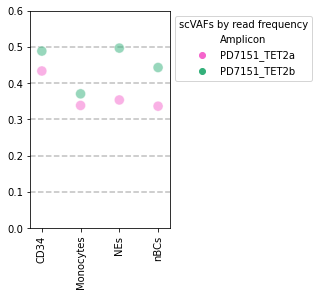

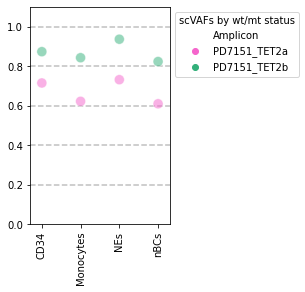

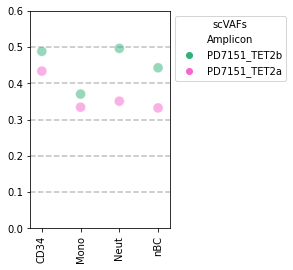

In [4]:
sourcefile = '../Data/Amp_data/allele_counts_anon.tsv'
metadata = '../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx'
pt_id = 'PD7151'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate2a = calc_scVAF(plate, pt_id, reads)
cutoff = 0.1
plate3a = calc_scVAF_binary_per_cell(plate, pt_id, reads, cutoff)
plate1a, PD7151qc = calc_scVAF_mod(plate, pt_id, reads)

PD7153
Cells with 10 reads  =  1177
Monocytes 308
NEs 120
nBCs 2
CD34+ 613
CD34+/38- 134
PD7153
Cells with 10 reads  =  1177
PD7153
Cells with 10 reads for amplicon PD7153_SRSF2  =  1325
Mono 322
Neut 165
nBC 21
CD34 817
Cells with 10 reads for amplicon PD7153_TET2a  =  1244
Mono 314
Neut 155
nBC 6
CD34 769
Cells with 10 reads for amplicon PD7153_TET2b  =  1177
Mono 308
Neut 120
nBC 2
CD34 747
[322, 165, 21, 817, 314, 155, 6, 769, 308, 120, 2, 747]
{'PD7153_TET2b': 0, 'PD7153_SRSF2': 1, 'PD7153_TET2a': 2}


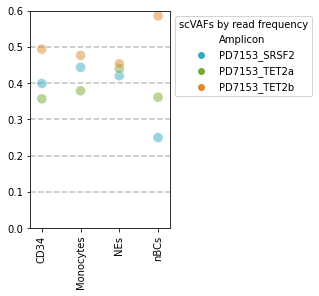

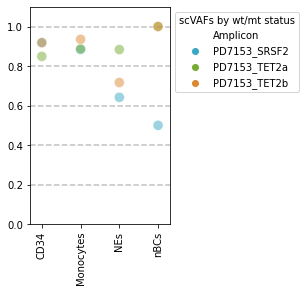

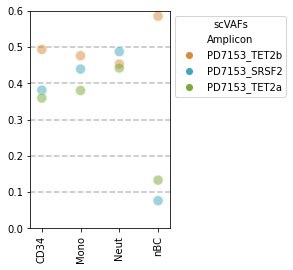

In [5]:
pt_id = 'PD7153'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate2b = calc_scVAF(plate, pt_id, reads)
cutoff = 0.1
plate3b = calc_scVAF_binary_per_cell(plate, pt_id, reads, cutoff)
plate1b, PD7153qc = calc_scVAF_mod(plate, pt_id, reads)

JP001
Cells with 10 reads  =  253
Monocytes 54
NEs 131
nBCs 50
CD34 15
CD34+/38- 3
JP001
Cells with 10 reads  =  253
JP001
Cells with 10 reads for amplicon JP001_RUNX1_g  =  2948
Mono 643
Neut 633
nBC 698
CD34 974
Cells with 10 reads for amplicon JP001_SRSF2  =  2414
Mono 588
Neut 248
nBC 679
CD34 899
Cells with 10 reads for amplicon JP001_TET2a  =  2257
Mono 558
Neut 242
nBC 643
CD34 814
Cells with 10 reads for amplicon JP001_TET2b_g  =  253
Mono 54
Neut 131
nBC 50
CD34 18
[643, 633, 698, 974, 588, 248, 679, 899, 558, 242, 643, 814, 54, 131, 50, 18]
{'JP001_SRSF2': 0, 'JP001_TET2a': 1, 'JP001_TET2b_g': 2, 'JP001_RUNX1_g': 3}


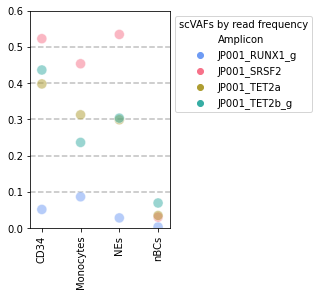

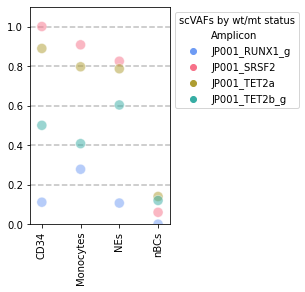

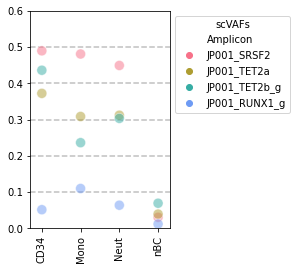

In [6]:
pt_id = 'JP001'
plate = data_retrieval(sourcefile, metadata, pt_id)
reads = 10
plate2c = calc_scVAF(plate, pt_id, reads)
cutoff = 0.1
plate3c = calc_scVAF_binary_per_cell(plate, pt_id, reads, cutoff)
plate1c, JP001qc = calc_scVAF_mod(plate, pt_id, reads)

In [7]:
# plate 3 - binary cutoffs as per haplotypes
frames = [plate3a, plate3b, plate3c]
plate3_all = pd.concat(frames)

pt_test = []
for index, row in plate3_all.iterrows():
    pt_test.append(row['Amplicon'].split('_')[0])

plate3_all['Pt'] = pt_test


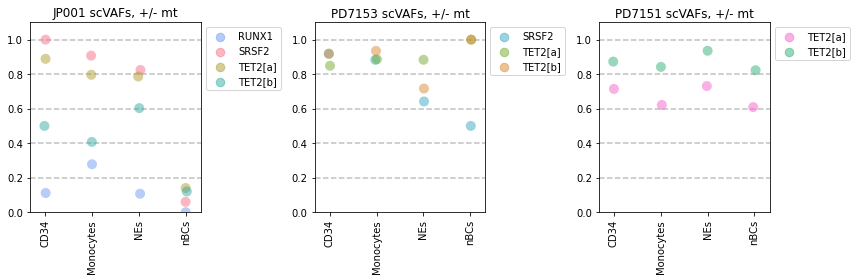

In [8]:
#plate3_all.sort_values(by=[['Sort_cell_type','Amplicon']], inplace = True)
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
short_label = ['SRSF2',
        'TET2[b]',
        'TET2[a]',
        'TET2[a]', 
        'TET2[b]',
        'TET2[b]', 
        'SRSF2', 
        'RUNX1',
        'CUX1',
        'TET2[a]'
       ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

fig, ax = plt.subplots(1, 3, figsize = (12,4))
for count, pt in enumerate(pts):
    sns.stripplot(x = 'Sort_cell_type', y = 'vaf', data = plate3_all.loc[plate3_all['Pt'].isin([pt])], jitter = 0.03, s = 10,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels()    

    lbl = []
    for lb in labels:
        lbl.append(relabel[lb])
    
    lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [1,1], markerscale = 1.1, handles=handles, labels=lbl)
    ax[count].set_ylim(0,1.1)
    #ax.axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.7, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.8, ls = '--', c = 'silver', zorder = 0)
    #ax.axhline(0.9, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(1.0, ls = '--', c = 'silver', zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].set_title(f'{pt} scVAFs, +/- mt')
    ax[count].margins(x=0.1)
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
fig.tight_layout()    
fig.savefig('../Results/sc_byhapcuts_VAFs.png',bbox_inches='tight', dpi = 300)

In [9]:
# plate 2 = 10 reads for all amps
frames = [plate2a, plate2b, plate2c]
plate2_all = pd.concat(frames)

pt_test = []
for index, row in plate2_all.iterrows():
    pt_test.append(row['Amplicon'].split('_')[0])

plate2_all['Pt'] = pt_test

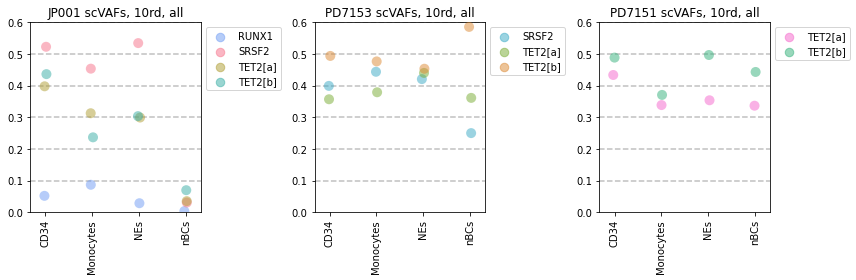

In [10]:
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
        'PD7153_TET2b',
        'JP001_TET2a',
        'PD7153_TET2a', 
        'PD7151_TET2b',
        'JP001_TET2b_g', 
        'PD7153_SRSF2', 
        'JP001_RUNX1_g',
        'PD7153_CUX1',
        'PD7151_TET2a'
       ]
short_label = ['SRSF2',
        'TET2[b]',
        'TET2[a]',
        'TET2[a]', 
        'TET2[b]',
        'TET2[b]', 
        'SRSF2', 
        'RUNX1',
        'CUX1',
        'TET2[a]'
       ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

fig, ax = plt.subplots(1, 3, figsize = (12,4))
for count, pt in enumerate(pts):
    sns.stripplot(x = 'sort_celltype', y = 'VAF', data = plate2_all.loc[plate2_all['Pt'].isin([pt])], jitter = 0.03, s = 10,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels()    
    lbl = []
    for lb in labels:
        lbl.append(relabel[lb])
    
    lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [1,1], markerscale = 1.1, handles=handles, labels=lbl)
    ax[count].set_ylim(0,0.6)
    ax[count].axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.7, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.8, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.9, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(1.0, ls = '--', c = 'silver', zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].set_title(f'{pt} scVAFs, 10rd, all')
    ax[count].margins(x=0.1)
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
    
fig.tight_layout()    
fig.savefig('../Results/sc_byreadfreq_VAFs.png',bbox_inches='tight', dpi = 300)

In [11]:
#Refinement - go ahead with frequencies bases on proportion of reads in each cell, but use any cell with at least x reads for that amplicon

In [12]:
#plate 1 - 10 reads for each amp
frames = [plate1a, plate1b, plate1c]
plate1_all = pd.concat(frames)

pt_test = []
for index, row in plate1_all.iterrows():
    pt_test.append(row['Amplicon'].split('_')[0])

plate1_all['Pt'] = pt_test

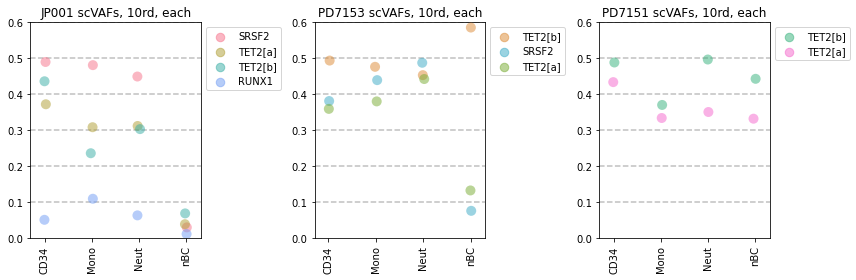

In [13]:
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
        'PD7153_TET2b',
        'JP001_TET2a',
        'PD7153_TET2a', 
        'PD7151_TET2b',
        'JP001_TET2b_g', 
        'PD7153_SRSF2', 
        'JP001_RUNX1_g',
        'PD7153_CUX1',
        'PD7151_TET2a'
       ]
short_label = ['SRSF2',
        'TET2[b]',
        'TET2[a]',
        'TET2[a]', 
        'TET2[b]',
        'TET2[b]', 
        'SRSF2', 
        'RUNX1',
        'CUX1',
        'TET2[a]'
       ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))


fig, ax = plt.subplots(1, 3, figsize = (12,4))
for count, pt in enumerate(pts):
    sns.stripplot(x = 'sort_celltype', y = 'VAF', data = plate1_all.loc[plate1_all['Pt'].isin([pt])], jitter = 0.03, s = 10,  hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels() 
    lbl = []
    for lb in labels:
        lbl.append(relabel[lb])
    
    lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [1,1], markerscale = 1.1, handles=handles, labels=lbl)
    ax[count].set_ylim(0,0.6)
    ax[count].axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.7, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.8, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(0.9, ls = '--', c = 'silver', zorder = 0)
    #ax[count].axhline(1.0, ls = '--', c = 'silver', zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].set_title(f'{pt} scVAFs, 10rd, each')
    ax[count].margins(x=0.1)
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
    
fig.tight_layout()    
fig.savefig('../Results/sc_byreadfreq_sepcells_VAFs_stripplot.png',bbox_inches='tight', dpi = 300)

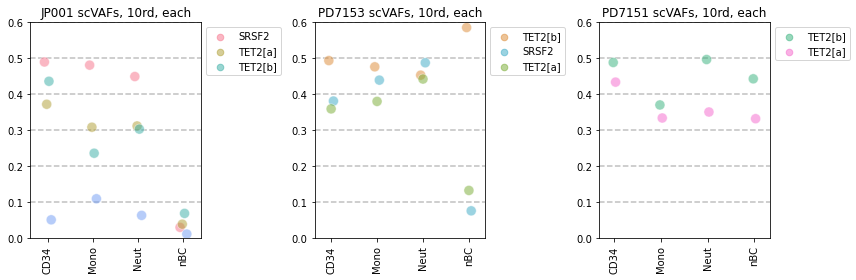

In [14]:
#Back to scatterplot using Fabio tweak - tweak the df first - plate 1 only
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
        'PD7153_TET2b',
        'JP001_TET2a',
        'PD7153_TET2a', 
        'PD7151_TET2b',
        'JP001_TET2b_g', 
        'PD7153_SRSF2', 
        'JP001_RUNX1_g',
        'PD7153_CUX1',
        'PD7151_TET2a'
       ]
short_label = ['SRSF2',
        'TET2[b]',
        'TET2[a]',
        'TET2[a]', 
        'TET2[b]',
        'TET2[b]', 
        'SRSF2', 
        'RUNX1',
        'CUX1',
        'TET2[a]'
       ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

#Convert categoricals to numbers on x axis
cell_order = ['CD34', 'Mono', 'Neut', 'nBC']
cell_order_map = {x:i for i, x in enumerate(cell_order)}

plate1_all['x_value'] = plate1_all['sort_celltype'].map(cell_order_map)

#Nudge all the points by tweaking x value
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_SRSF2', 'x_value'] -= 0.075
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_TET2a', 'x_value'] -= 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_TET2b_g', 'x_value'] += 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_RUNX1_g', 'x_value'] += 0.075

plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_TET2b', 'x_value'] -= 0.05
#plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_TET2a', 'x_value'] -= 0.0
plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_SRSF2', 'x_value'] += 0.05

plate1_all.loc[plate1_all['Amplicon'] == 'PD7151_TET2b', 'x_value'] -= 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'PD7151_TET2a', 'x_value'] += 0.025



fig, ax = plt.subplots(1, 3, figsize = (12,4))

for count, pt in enumerate(pts):
    data = plate1_all.loc[plate1_all['Pt'].isin([pt])]
    sns.scatterplot(x = 'x_value', y = 'VAF', data = data, s = 100, hue = 'Amplicon', palette = allVAFcols, alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels() 
    lbl = []
    for lb in labels[1:4]:
        lbl.append(relabel[lb])
    
    lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [1,1], markerscale = 1.1, handles=handles[1:4], labels=lbl)
    ax[count].set_ylim(0,0.6)
    ax[count].axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].set_title(f'{pt} scVAFs, 10rd, each')
    ax[count].margins(x=0.1)
    #Manually adjust ticks and labels since now plotting ot arbitrary x values
    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)


        
fig.tight_layout()    
fig.savefig('../Results/sc_byreadfreq_sepcells_VAFs.png',bbox_inches='tight', dpi = 300)

In [15]:
#Try to tweak and get dot size to reflect number of cells represented, back to scatterplot using Fabio tweak
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
short_label = ['SRSF2',
        'TET2[b]',
        'TET2[a]',
        'TET2[a]', 
        'TET2[b]',
        'TET2[b]', 
        'SRSF2', 
        'RUNX1',
        'CUX1',
        'TET2[a]'
       ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

#Convert categoricals to numbers on x axis
cell_order = ['CD34', 'Mono', 'Neut', 'nBC']
cell_order_map = {x:i for i, x in enumerate(cell_order)}

plate1_all['x_value'] = plate1_all['sort_celltype'].map(cell_order_map)

#Nudge all the points by tweaking x value
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_SRSF2', 'x_value'] -= 0.075
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_TET2a', 'x_value'] -= 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_TET2b_g', 'x_value'] += 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_RUNX1_g', 'x_value'] += 0.075

plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_TET2b', 'x_value'] -= 0.05
#plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_TET2a', 'x_value'] -= 0.0
plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_SRSF2', 'x_value'] += 0.05

plate1_all.loc[plate1_all['Amplicon'] == 'PD7151_TET2b', 'x_value'] -= 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'PD7151_TET2a', 'x_value'] += 0.025

#Tweak the cell number to get dot size
plate1_all['dot_size'] = plate1_all['numcell']

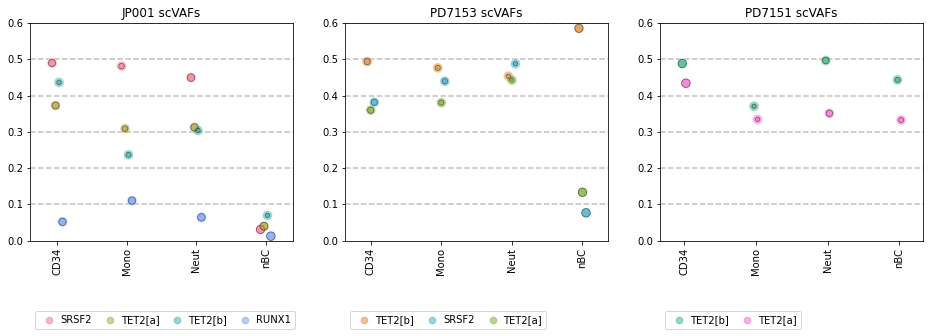

In [16]:
#Then plot tweaked plate 1

fig, ax = plt.subplots(1, 3, figsize = (16,4))

for count, pt in enumerate(pts):
    data = plate1_all.loc[plate1_all['Pt'].isin([pt])]
    
    sns.scatterplot(x = 'x_value', y = 'VAF', data = data, s = 100, hue = 'Amplicon', palette = allVAFcols,  alpha = 0.5, ax = ax[count])
    sns.scatterplot(x = 'x_value', y = 'VAF', data = data, size = 'dot_size', hue = 'Amplicon', palette = allVAFcols, edgecolor = 'black', zorder = 10, alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels() 
    #rename labels for amplicons
    lbl = [] 
    for lb in labels:
        if lb not in all_amps:
            lbl.append(lb)
        else:
            lbl.append(relabel[lb])
                
            
    #sns.scatterplot(x = 'x_value', y = 'VAF', data = data, s = 100, hue = 'Amplicon', palette = allVAFcols,  alpha = 0.5, ax = ax[count])
    
    if pt == 'JP001':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[1:5], labels=lbl[1:5])
    elif pt == 'PD7153':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[1:4], labels=lbl[1:4])
    elif pt == 'PD7151':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[1:3], labels=lbl[1:3])

    
    ax[count].set_ylim(0,0.6)
    ax[count].axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].set_title(f'{pt} scVAFs')
    ax[count].margins(x=0.1)
    #Manually adjust ticks and labels since now plotting at arbitrary x values
    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)

        
#fig.tight_layout()    
fig.savefig('../Results/sc_byreadfreq_sepcells_VAFs_size.png',bbox_inches='tight', dpi = 300)

In [17]:
bd_df = plate1_all.copy()
#Nudge all the points by tweaking x value
bd_df.loc[bd_df['Amplicon'] == 'JP001_SRSF2', 'x_value'] -= 0.15
bd_df.loc[bd_df['Amplicon'] == 'JP001_TET2a', 'x_value'] -= 0.05
bd_df.loc[bd_df['Amplicon'] == 'JP001_TET2b_g', 'x_value'] += 0.05
bd_df.loc[bd_df['Amplicon'] == 'JP001_RUNX1_g', 'x_value'] += 0.15

bd_df.loc[bd_df['Amplicon'] == 'PD7153_TET2b', 'x_value'] -= 0.1
#bd_df.loc[bd_df['Amplicon'] == 'PD7153_TET2a', 'x_value'] -= 0.0
bd_df.loc[bd_df['Amplicon'] == 'PD7153_SRSF2', 'x_value'] += 0.1

bd_df.loc[bd_df['Amplicon'] == 'PD7151_TET2b', 'x_value'] -= 0.05
bd_df.loc[bd_df['Amplicon'] == 'PD7151_TET2a', 'x_value'] += 0.05

bar_data = bd_df.groupby(['Pt', 'sort_celltype', 'Amplicon']).mean()
bar_data.drop(columns = ['VAF', 'dot_size'], inplace = True)
bar_data['Pt'] = bar_data.index.get_level_values(0)
bar_data['Amplicon'] = bar_data.index.get_level_values(2)
bar_data.head()
#plate1_all.head()

numcell  order  x_value     Pt  \
Pt    sort_celltype Amplicon                                        
JP001 CD34          JP001_RUNX1_g      643      3    0.225  JP001   
                    JP001_SRSF2        588      0   -0.225  JP001   
                    JP001_TET2a        558      1   -0.075  JP001   
                    JP001_TET2b_g       54      2    0.075  JP001   
      Mono          JP001_RUNX1_g      633      3    1.225  JP001   

                                        Amplicon  
Pt    sort_celltype Amplicon                      
JP001 CD34          JP001_RUNX1_g  JP001_RUNX1_g  
                    JP001_SRSF2      JP001_SRSF2  
                    JP001_TET2a      JP001_TET2a  
                    JP001_TET2b_g  JP001_TET2b_g  
      Mono          JP001_RUNX1_g  JP001_RUNX1_g

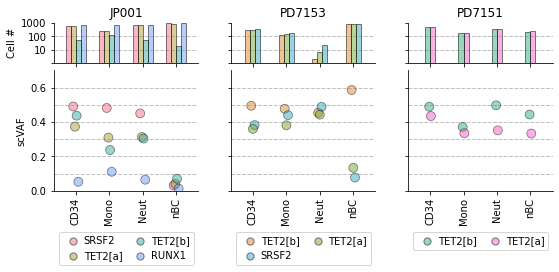

In [69]:
#Plot small bargraph underneath with cell number
fig, (ax1,ax2) = plt.subplots(2, 3, figsize = (8,4), gridspec_kw = dict(height_ratios = [1,3]), sharex = True) #gridspec_kw takes a dict, keys can include height ratios (for every row, what is the height) and width ratio

ax = ax1
for count, pt in enumerate(pts):
    data = bar_data.loc[bar_data['Pt'].isin([pt])]
    #x = data['x_value']
    #y = data['numcell']
    
    for i, row in data.iterrows():
        x = row['x_value']
        y = row['numcell']
        color = allVAFcols[row['Amplicon']]
        
        ax[count].bar([x], [y], width = 0.15, color = color, alpha = 0.5,  edgecolor = 'black')
    

    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    ax[count].set_yscale('log')
    ax[count].set_ylim(1, 1000)
    ax[count].set_yticks([1, 10, 100, 1000])
    ax1labels = ['', 10, 100, 1000]
    ax[count].set_yticklabels(ax1labels)
    ax[count].spines['top'].set_visible(False)
    ax[count].spines['right'].set_visible(False)
    if count != 0:
        ax[count].set_yticklabels([])
    else:
        ax[count].set_ylabel('Cell #')
    
    #ax[count].set_yticklabels(1, 1000)
    ax[count].axhline(10, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(100, ls = '--', c = 'silver', lw = 1, zorder = 0)

ax = ax2

for count, pt in enumerate(pts):
    
    data = plate1_all.loc[plate1_all['Pt'].isin([pt])]
    
    sns.scatterplot(x = 'x_value', y = 'VAF', data = data, s = 80, hue = 'Amplicon', palette = allVAFcols,  edgecolor = 'black', alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels() 
    #rename labels for amplicons
    lbl = [] 
    for lb in labels:
        if lb not in all_amps:
            lbl.append(lb)
        else:
            lbl.append(relabel[lb])
                
    
    if pt == 'JP001':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 2, markerscale = 1.2, handles=handles[1:5], labels=lbl[1:5])
    elif pt == 'PD7153':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 2, markerscale = 1.2, handles=handles[1:4], labels=lbl[1:4])
    elif pt == 'PD7151':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 2, markerscale = 1.2, handles=handles[1:3], labels=lbl[1:3])

    
    ax[count].set_ylim(0,0.7)
    ax[count].axhline(0.1, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', lw = 1, zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax1[count].set_title(f'{pt}')
    ax[count].margins(x=0.1)
    
    if count != 0:
        ax[count].set_yticklabels([])
    else:
        ax[count].set_ylabel('scVAF')
    
    #Manually adjust ticks and labels since now plotting at arbitrary x values
    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    
    ax[count].spines['top'].set_visible(False)
    ax[count].spines['right'].set_visible(False)
    
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
        lh.set_edgecolor('black')
        
    
fig.tight_layout(h_pad = 0, w_pad = 2)  
fig.savefig('../Results/sc_VAFs_cell_no.png',bbox_inches='tight', dpi = 600)

In [19]:
allVAFcols

{'JP001_SRSF2': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 'PD7153_TET2b': (0.8616090647292522, 0.536495730113334, 0.19548899031476086),
 'JP001_TET2a': (0.6804189127793346, 0.6151497514677574, 0.19405452111445337),
 'PD7153_TET2a': (0.46810256823426105, 0.6699492535792404, 0.1928958739904499),
 'PD7151_TET2b': (0.20125317221201128,
  0.6907920815379025,
  0.47966761189275336),
 'JP001_TET2b_g': (0.21044753832183283,
  0.6773105080456748,
  0.6433941168468681),
 'PD7153_SRSF2': (0.2197995660828324, 0.6625157876850336, 0.7732093159317209),
 'JP001_RUNX1_g': (0.433280341176423, 0.6065273407962815, 0.9585467098271748),
 'PD7153_CUX1': (0.8004936186423958, 0.47703363533737203, 0.9579547196007522),
 'PD7151_TET2a': (0.962272393509669, 0.3976451968965351, 0.8008274363432775)}

['JP001_RUNX1_g', 'JP001_SRSF2', 'JP001_TET2a', 'JP001_TET2b_g']
['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
['PD7151_TET2a', 'PD7151_TET2b']


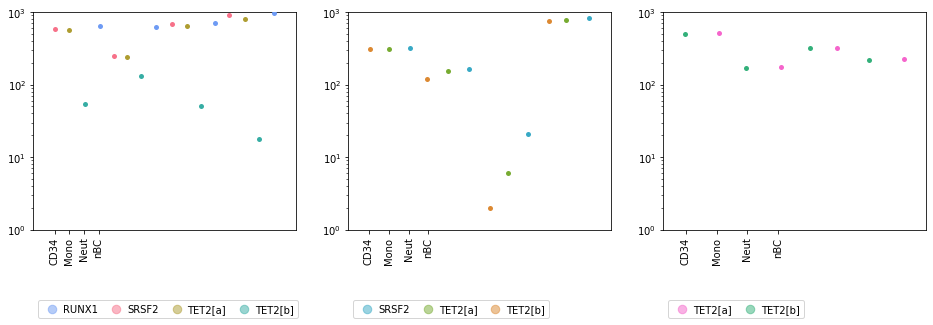

In [20]:
#Plot small bargraph underneath with cell number
fig, ax = plt.subplots(1, 3, figsize = (16,4))

for count, pt in enumerate(pts):
    data = bar_data.loc[bar_data['Pt'].isin([pt])]
    
    sns.stripplot(x = 'x_value', y = 'numcell', data = data, hue = 'Amplicon', palette = allVAFcols, ax = ax[count])
    
    handles, labels = ax[count].get_legend_handles_labels() 
    #rename labels for amplicons
    lbl = [] 
    for lb in labels:
        if lb not in all_amps:
            lbl.append(lb)
        else:
            lbl.append(relabel[lb])
    
    if pt == 'JP001':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[0:4], labels=lbl[0:4])
    elif pt == 'PD7153':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[0:4], labels=lbl[0:4])
    elif pt == 'PD7151':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[0:3], labels=lbl[0:3])

    
    ax[count].set_ylim(1,1000)
    ax[count].set_yscale('log')
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].margins(x=0.1)
    #Manually adjust ticks and labels since now plotting at arbitrary x values
    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
        
    print(labels)    

In [21]:
np.arange(len(cell_order))

array([0, 1, 2, 3])

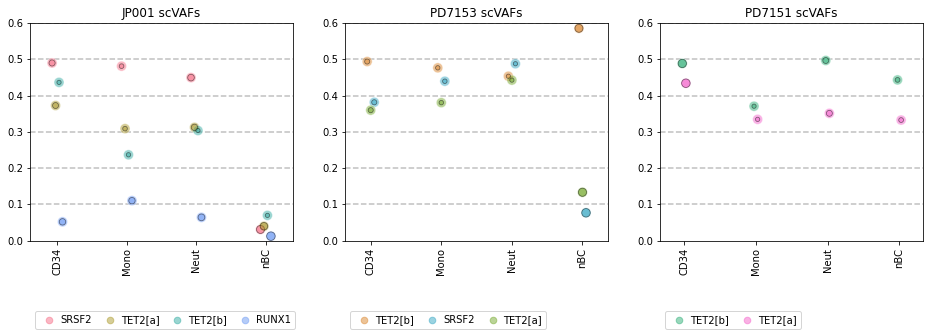

In [22]:
#Adding dot size as extra legend artist - trying anyway
pts = ['JP001', 'PD7153', 'PD7151']

all_amps = ['JP001_SRSF2',
            'PD7153_TET2b',
            'JP001_TET2a',
            'PD7153_TET2a', 
            'PD7151_TET2b',
            'JP001_TET2b_g', 
            'PD7153_SRSF2', 
            'JP001_RUNX1_g',
            'PD7153_CUX1',
            'PD7151_TET2a'
           ]
short_label = ['SRSF2',
        'TET2[b]',
        'TET2[a]',
        'TET2[a]', 
        'TET2[b]',
        'TET2[b]', 
        'SRSF2', 
        'RUNX1',
        'CUX1',
        'TET2[a]'
       ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

#Convert categoricals to numbers on x axis
cell_order = ['CD34', 'Mono', 'Neut', 'nBC']
cell_order_map = {x:i for i, x in enumerate(cell_order)}

plate1_all['x_value'] = plate1_all['sort_celltype'].map(cell_order_map)

#Nudge all the points by tweaking x value
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_SRSF2', 'x_value'] -= 0.075
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_TET2a', 'x_value'] -= 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_TET2b_g', 'x_value'] += 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'JP001_RUNX1_g', 'x_value'] += 0.075

plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_TET2b', 'x_value'] -= 0.05
#plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_TET2a', 'x_value'] -= 0.0
plate1_all.loc[plate1_all['Amplicon'] == 'PD7153_SRSF2', 'x_value'] += 0.05

plate1_all.loc[plate1_all['Amplicon'] == 'PD7151_TET2b', 'x_value'] -= 0.025
plate1_all.loc[plate1_all['Amplicon'] == 'PD7151_TET2a', 'x_value'] += 0.025

#Tweak the cell number to get dot size
plate1_all['dot_size'] = plate1_all['numcell']**2



fig, ax = plt.subplots(1, 3, figsize = (16,4))


for count, pt in enumerate(pts):
    data = plate1_all.loc[plate1_all['Pt'].isin([pt])]
    
    sns.scatterplot(x = 'x_value', y = 'VAF', data = data, size = 'dot_size', hue = 'Amplicon', palette = allVAFcols, edgecolor = 'black', zorder = 10, alpha = 0.5, ax = ax[count])
    handles, labels = ax[count].get_legend_handles_labels() 
    #rename labels for amplicons
    lbl = [] 
    for lb in labels:
        if lb not in all_amps:
            lbl.append(lb)
        else:
            lbl.append(relabel[lb])
                
            
    sns.scatterplot(x = 'x_value', y = 'VAF', data = data, s = 100, hue = 'Amplicon', palette = allVAFcols,  alpha = 0.5, ax = ax[count])
    
    if pt == 'JP001':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[1:5], labels=lbl[1:5])
    elif pt == 'PD7153':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[1:4], labels=lbl[1:4])
    elif pt == 'PD7151':
        lgd = ax[count].legend(loc = 'upper left', bbox_to_anchor = [0,-0.3], columnspacing = 0.8, handletextpad=0.1, ncol = 4, markerscale = 1.1, handles=handles[1:3], labels=lbl[1:3])

    ax[count].set_ylim(0,0.6)
    ax[count].axhline(0.1, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.2, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.3, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.4, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.5, ls = '--', c = 'silver', zorder = 0)
    ax[count].axhline(0.6, ls = '--', c = 'silver', zorder = 0)
    ax[count].set_ylabel('')
    ax[count].set_xlabel('')
    ax[count].tick_params(axis='x', labelrotation = 90)
    ax[count].set_title(f'{pt} scVAFs')
    ax[count].margins(x=0.1)
    #Manually adjust ticks and labels since now plotting ot arbitrary x values
    ax[count].set_xticks(np.arange(len(cell_order)))
    ax[count].set_xticklabels(cell_order)
    for lh in lgd.legendHandles: 
        lh.set_alpha(0.5)
        
    #Make an extra legend to show sizes
    #s_hand = [plt.plot([],[], color = 'black', alpha = 0.5, marker = 'o', ms = i, ls = '')[0] for i in [12, 60, 300, 1200]]
    #s_labs = ['12', '60', '300', '1200']
    #sleg = plt.legend(bbox_to_anchor = [0,-0.5], columnspacing = 0.8, handletextpad=0.1, ncol = 4,  handles=s_hand, labels=s_labs)        
    #ax[count].add_artist(sleg)



        
#fig.tight_layout()    
fig.savefig('../Results/sc_byreadfreq_sepcells_VAFs_size_lgdtest.png',bbox_inches='tight', dpi = 300)

In [23]:
#QC
#WHY do the EL plots look so different for srsf2 and tet2a in nBC. Export to excel to look
#Easier to check in python - answer is very few cells have 10 reads for each, so distribution is v. skewed
#Also exporting data for Chris to choose wells for amplicon rescue


In [24]:
pt_id = 'PD7153'
PD7153plate = data_retrieval(sourcefile, metadata, pt_id)
PD7153plate = PD7153plate.groupby(['Plate', 'Well', 'Cell_type', 'Amplicon']).sum().unstack()
PD7153plate.columns = ['PD7153_CUX1', 'PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b', 'PD7153_TGFB3_c', 'PD7153_TGFB3_g']
PD7153plate['Plate'] = PD7153plate.index.get_level_values(0)
PD7153plate

PD7153_CUX1  PD7153_SRSF2  PD7153_TET2a  PD7153_TET2b  \
Plate  Well Cell_type                                                          
AS-202 A1   Monocytes          NaN           0.0           1.0           1.0   
       A10  Monocytes          NaN           0.0           2.0           0.0   
       A11  Monocytes          NaN           0.0          14.0           8.0   
       A12  Monocytes          NaN           6.0          33.0          47.0   
       A13  Monocytes          NaN          13.0          43.0          41.0   
...                            ...           ...           ...           ...   
AS-210 P5   CD34+/38-          0.0           0.0          17.0          21.0   
       P6   CD34+/38-          0.0          13.0           0.0           2.0   
       P7   CD34+/38-          0.0           0.0           1.0           3.0   
       P8   CD34+/38-          0.0          21.0           3.0           4.0   
       P9   CD34+/38-          0.0          16.0           1.0           3.0   

                       PD7153_TGFB3_c  PD7153_TGFB3_g   Plate  
Plate  Well Cell_type                                          
AS-202 A1   Monocytes             0.0             0.0  AS-202  
       A10  Monocytes             0.0             0.0  AS-202  
       A11  Monocytes             0.0             0.0  AS-202  
       A12  Monocytes             0.0             3.0  AS-202  
       A13  Monocytes             0.0             2.0  AS-202  
...                               ...             ...     ...  
AS-210 P5   CD34+/38-             1.0            20.0  AS-210  
       P6   CD34+/38-             0.0             0.0  AS-210  
       P7   CD34+/38-             0.0             0.0  AS-210  
       P8   CD34+/38-             0.0             0.0  AS-210  
       P9   CD34+/38-             0.0             2.0  AS-210  

[3456 rows x 7 columns]

In [25]:
pt_id = 'PD7151'
PD7151plate = data_retrieval(sourcefile, metadata, pt_id)
PD7151plate = PD7151plate.groupby(['Plate', 'Well', 'Cell_type', 'Amplicon']).sum().unstack()
PD7151plate.columns = ['PD7151_TET2a', 'PD7151_TET2b']
PD7151plate['Plate'] = PD7151plate.index.get_level_values(0)
PD7151plate

PD7151_TET2a  PD7151_TET2b   Plate
Plate  Well Cell_type                                         
AS-214 A1   Monocytes                1.0          30.0  AS-214
       A10  Monocytes                1.0          28.0  AS-214
       A11  Monocytes                2.0          42.0  AS-214
       A12  Monocytes                8.0         783.0  AS-214
       A13  Monocytes                9.0         530.0  AS-214
...                                  ...           ...     ...
AS-223 P5   CD34+halfCD38-           3.0          17.0  AS-223
       P6   CD34+halfCD38-           0.0         519.0  AS-223
       P7   CD34+halfCD38-           1.0         200.0  AS-223
       P8   CD34+halfCD38-           0.0         352.0  AS-223
       P9   CD34+halfCD38-           0.0          67.0  AS-223

[3456 rows x 3 columns]

In [26]:
pt_id = 'JP001'
JP001plate = data_retrieval(sourcefile, metadata, pt_id)
JP001plate = JP001plate.groupby(['Plate', 'Well', 'Cell_type', 'Amplicon']).sum().unstack()
JP001plate.columns = ['JP001_RUNX1_c','JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_c','JP001_TET2b_g']
JP001plate['Plate'] = JP001plate.index.get_level_values(0)
JP001plate

JP001_RUNX1_c  JP001_RUNX1_g  JP001_SRSF2  JP001_TET2a  \
Plate  Well Cell_type                                                           
AS-187 A1   Monocytes            3.0           88.0         12.0        144.0   
       A10  Monocytes            1.0            3.0          3.0          0.0   
       A11  Monocytes            1.0            3.0        389.0          3.0   
       A12  Monocytes           14.0          129.0         24.0         20.0   
       A13  Monocytes           27.0          136.0         17.0         29.0   
...                              ...            ...          ...          ...   
AS-201 P5   CD34+/38-            0.0            0.0          2.0          0.0   
       P6   CD34+/38-           29.0           13.0          5.0          6.0   
       P7   CD34+/38-            9.0            4.0          2.0          3.0   
       P8   CD34+/38-           52.0           23.0          9.0          7.0   
       P9   CD34+/38-           44.0           19.0          3.0          5.0   

                       JP001_TET2b_c  JP001_TET2b_g   Plate  
Plate  Well Cell_type                                        
AS-187 A1   Monocytes            0.0            0.0  AS-187  
       A10  Monocytes            0.0            0.0  AS-187  
       A11  Monocytes            0.0            0.0  AS-187  
       A12  Monocytes            0.0            0.0  AS-187  
       A13  Monocytes            0.0            0.0  AS-187  
...                              ...            ...     ...  
AS-201 P5   CD34+/38-            NaN            0.0  AS-201  
       P6   CD34+/38-            NaN            0.0  AS-201  
       P7   CD34+/38-            NaN            0.0  AS-201  
       P8   CD34+/38-            NaN            0.0  AS-201  
       P9   CD34+/38-            NaN            0.0  AS-201  

[3456 rows x 7 columns]

In [27]:
#Put all counts in a file for Chris
with pd.ExcelWriter('../Results/All_pt_read_per_amplicon.xlsx',
                    mode='w') as writer:  
    JP001plate.to_excel(writer, sheet_name='JP001')
    PD7153plate.to_excel(writer, sheet_name='PD7153')
    PD7151plate.to_excel(writer, sheet_name='PD7151')

In [28]:
key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
plate_cell_dict = dict(zip(key.Plate, key.Celltype))


JP001qc['Total'] = JP001qc.iloc[: , 0] + JP001qc.iloc[: , 1]
JP001qc['Mut_freq'] = JP001qc.iloc[:, 0]/JP001qc['Total']
JP001qc = JP001qc.loc[JP001qc['Total'] >= 1]
JP001qc = JP001qc.reset_index()
JP001qc['Plate_Well'] = JP001qc['Plate'].astype(str) + '_' + JP001qc['Well'].astype(str)
JP001qc['celltype'] = JP001qc['Plate'].replace(plate_cell_dict)
JP001qc = JP001qc.loc[JP001qc['Amplicon'].isin(['JP001_RUNX1_g','JP001_SRSF2','JP001_TET2a','JP001_TET2b_g'])]
JP001qc = JP001qc.drop(columns = ['Plate', 'Well'])

PD7153qc['Total'] = PD7153qc.iloc[: , 0] + PD7153qc.iloc[: , 1]
PD7153qc['Mut_freq'] = PD7153qc.iloc[:, 0]/PD7153qc['Total']
PD7153qc = PD7153qc.loc[PD7153qc['Total'] >= 1]
PD7153qc = PD7153qc.reset_index()
PD7153qc['Plate_Well'] = PD7153qc['Plate'].astype(str) + '_' + PD7153qc['Well'].astype(str)
PD7153qc['celltype'] = PD7153qc['Plate'].replace(plate_cell_dict)
PD7153qc = PD7153qc.loc[PD7153qc['Amplicon'].isin(['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b'])]
PD7153qc = PD7153qc.drop(columns = ['Plate', 'Well'])

PD7151qc['Total'] = PD7151qc.iloc[: , 0] + PD7151qc.iloc[: , 1]
PD7151qc['Mut_freq'] = PD7151qc.iloc[:, 0]/PD7151qc['Total']
PD7151qc = PD7151qc.loc[PD7151qc['Total'] >= 1]
PD7151qc = PD7151qc.reset_index()
PD7151qc['Plate_Well'] = PD7151qc['Plate'].astype(str) + '_' + PD7151qc['Well'].astype(str)
PD7151qc['celltype'] = PD7151qc['Plate'].replace(plate_cell_dict)
PD7151qc = PD7151qc.loc[PD7151qc['Amplicon'].isin(['PD7151_TET2a', 'PD7151_TET2b'])]
PD7151qc = PD7151qc.drop(columns = ['Plate', 'Well'])


C:\Users\z3283497\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [29]:
#Put all qc in a file
with pd.ExcelWriter('../Results/All_pt_MTreadfreq_per_amplicon.xlsx',
                    mode='w') as writer:  #mode = w to write, mode = a to append (presumably to an exisitng file?)
    JP001qc.to_excel(writer, sheet_name='JP001')
    PD7153qc.to_excel(writer, sheet_name='PD7153')
    PD7151qc.to_excel(writer, sheet_name='PD7151')

In [30]:
print('total nBCs = ', len(PD7153qc.loc[PD7153qc['celltype'].isin(['nBCs'])]))
nBC = PD7153qc.loc[PD7153qc['celltype'].isin(['nBCs'])]
print('10 read any nBCs = ', len(nBC.loc[nBC['Total'] >= 10]))

print('10 read TET2a nBCs = ', len(nBC.loc[(nBC['Amplicon'].isin(['PD7153_TET2a'])) & (nBC['Total'] >= 10)]))
print('10 read TET2b nBCs = ', len(nBC.loc[(nBC['Amplicon'].isin(['PD7153_TET2b'])) & (nBC['Total'] >= 10)]))
print('10 read SRSF2 nBCs = ', len(nBC.loc[(nBC['Amplicon'].isin(['PD7153_SRSF2'])) & (nBC['Total'] >= 10)]))

#Which wells have at least 10 reads for all cells?
nBC10 = nBC.drop(columns = ['Reads', 'Mut_freq'])
nBC10 = nBC10.set_index(['Plate_Well', 'celltype', 'Amplicon'])
nBC10 = nBC10.unstack(level = 2)
nBC10.columns = ['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']
print('10 read all amp nBCs = ', (nBC10.loc[(nBC10[['PD7153_SRSF2', 'PD7153_TET2a', 'PD7153_TET2b']] >= 10).all(axis = 1)]).shape[0])


total nBCs =  1046
10 read any nBCs =  102
10 read TET2a nBCs =  59
10 read TET2b nBCs =  22
10 read SRSF2 nBCs =  21
10 read all amp nBCs =  2


In [70]:
bar_data

numcell  order  x_value      Pt  \
Pt     sort_celltype Amplicon                                         
JP001  CD34          JP001_RUNX1_g      643      3    0.225   JP001   
                     JP001_SRSF2        588      0   -0.225   JP001   
                     JP001_TET2a        558      1   -0.075   JP001   
                     JP001_TET2b_g       54      2    0.075   JP001   
       Mono          JP001_RUNX1_g      633      3    1.225   JP001   
                     JP001_SRSF2        248      0    0.775   JP001   
                     JP001_TET2a        242      1    0.925   JP001   
                     JP001_TET2b_g      131      2    1.075   JP001   
       Neut          JP001_RUNX1_g      698      3    2.225   JP001   
                     JP001_SRSF2        679      0    1.775   JP001   
                     JP001_TET2a        643      1    1.925   JP001   
                     JP001_TET2b_g       50      2    2.075   JP001   
       nBC           JP001_RUNX1_g      974      3    3.225   JP001   
                     JP001_SRSF2        899      0    2.775   JP001   
                     JP001_TET2a        814      1    2.925   JP001   
                     JP001_TET2b_g       18      2    3.075   JP001   
PD7151 CD34          PD7151_TET2a       508      1    0.075  PD7151   
                     PD7151_TET2b       494      0   -0.075  PD7151   
       Mono          PD7151_TET2a       175      1    1.075  PD7151   
                     PD7151_TET2b       171      0    0.925  PD7151   
       Neut          PD7151_TET2a       324      1    2.075  PD7151   
                     PD7151_TET2b       322      0    1.925  PD7151   
       nBC           PD7151_TET2a       223      1    3.075  PD7151   
                     PD7151_TET2b       220      0    2.925  PD7151   
PD7153 CD34          PD7153_SRSF2       322      1    0.150  PD7153   
                     PD7153_TET2a       314      2    0.000  PD7153   
                     PD7153_TET2b       308      0   -0.150  PD7153   
       Mono          PD7153_SRSF2       165      1    1.150  PD7153   
                     PD7153_TET2a       155      2    1.000  PD7153   
                     PD7153_TET2b       120      0    0.850  PD7153   
       Neut          PD7153_SRSF2        21      1    2.150  PD7153   
                     PD7153_TET2a         6      2    2.000  PD7153   
                     PD7153_TET2b         2      0    1.850  PD7153   
       nBC           PD7153_SRSF2       817      1    3.150  PD7153   
                     PD7153_TET2a       769      2    3.000  PD7153   
                     PD7153_TET2b       747      0    2.850  PD7153   

                                         Amplicon  
Pt     sort_celltype Amplicon                      
JP001  CD34          JP001_RUNX1_g  JP001_RUNX1_g  
                     JP001_SRSF2      JP001_SRSF2  
                     JP001_TET2a      JP001_TET2a  
                     JP001_TET2b_g  JP001_TET2b_g  
       Mono          JP001_RUNX1_g  JP001_RUNX1_g  
                     JP001_SRSF2      JP001_SRSF2  
                     JP001_TET2a      JP001_TET2a  
                     JP001_TET2b_g  JP001_TET2b_g  
       Neut          JP001_RUNX1_g  JP001_RUNX1_g  
                     JP001_SRSF2      JP001_SRSF2  
                     JP001_TET2a      JP001_TET2a  
                     JP001_TET2b_g  JP001_TET2b_g  
       nBC           JP001_RUNX1_g  JP001_RUNX1_g  
                     JP001_SRSF2      JP001_SRSF2  
                     JP001_TET2a      JP001_TET2a  
                     JP001_TET2b_g  JP001_TET2b_g  
PD7151 CD34          PD7151_TET2a    PD7151_TET2a  
                     PD7151_TET2b    PD7151_TET2b  
       Mono          PD7151_TET2a    PD7151_TET2a  
                     PD7151_TET2b    PD7151_TET2b  
       Neut          PD7151_TET2a    PD7151_TET2a  
                     PD7151_TET2b    PD7151_TET2b  
       nBC           PD7151_TET2a    PD7151_TET2a  
                     PD7151_TET2b    

In [71]:
plate1_all

VAF sort_celltype       Amplicon  numcell  \
              Sort_cell_type                                                   
PD7151_TET2b  CD34            0.488673          CD34   PD7151_TET2b      494   
              Mono            0.370720          Mono   PD7151_TET2b      171   
              Neut            0.496906          Neut   PD7151_TET2b      322   
              nBC             0.443317           nBC   PD7151_TET2b      220   
PD7151_TET2a  CD34            0.434143          CD34   PD7151_TET2a      508   
              Mono            0.334491          Mono   PD7151_TET2a      175   
              Neut            0.351129          Neut   PD7151_TET2a      324   
              nBC             0.332549           nBC   PD7151_TET2a      223   
PD7153_TET2b  CD34            0.493987          CD34   PD7153_TET2b      308   
              Mono            0.476650          Mono   PD7153_TET2b      120   
              Neut            0.453507          Neut   PD7153_TET2b        2   
              nBC             0.585714           nBC   PD7153_TET2b      747   
PD7153_SRSF2  CD34            0.381592          CD34   PD7153_SRSF2      322   
              Mono            0.439680          Mono   PD7153_SRSF2      165   
              Neut            0.487905          Neut   PD7153_SRSF2       21   
              nBC             0.076648           nBC   PD7153_SRSF2      817   
PD7153_TET2a  CD34            0.359796          CD34   PD7153_TET2a      314   
              Mono            0.380590          Mono   PD7153_TET2a      155   
              Neut            0.442720          Neut   PD7153_TET2a        6   
              nBC             0.133275           nBC   PD7153_TET2a      769   
JP001_SRSF2   CD34            0.490063          CD34    JP001_SRSF2      588   
              Mono            0.481298          Mono    JP001_SRSF2      248   
              Neut            0.449662          Neut    JP001_SRSF2      679   
              nBC             0.030704           nBC    JP001_SRSF2      899   
JP001_TET2a   CD34            0.372637          CD34    JP001_TET2a      558   
              Mono            0.308883          Mono    JP001_TET2a      242   
              Neut            0.312349          Neut    JP001_TET2a      643   
              nBC             0.039531           nBC    JP001_TET2a      814   
JP001_TET2b_g CD34            0.436482          CD34  JP001_TET2b_g       54   
              Mono            0.236630          Mono  JP001_TET2b_g      131   
              Neut            0.303654          Neut  JP001_TET2b_g       50   
              nBC             0.069505           nBC  JP001_TET2b_g       18   
JP001_RUNX1_g CD34            0.051698          CD34  JP001_RUNX1_g      643   
              Mono            0.110172          Mono  JP001_RUNX1_g      633   
              Neut            0.064032          Neut  JP001_RUNX1_g      698   
              nBC             0.012128           nBC  JP001_RUNX1_g      974   

                              order      Pt  x_value  dot_size  
              Sort_cell_type                                    
PD7151_TET2b  CD34                0  PD7151   -0.025    244036  
              Mono                0  PD7151    0.975     29241  
              Neut                0  PD7151    1.975    103684  
              nBC                 0  PD7151    2.975     48400  
PD7151_TET2a  CD34                1  PD7151    0.025    258064  
              Mono                1  PD7151    1.025     30625  
              Neut                1  PD7151    2.025    104976  
              nBC                 1  PD7151    3.025     49729  
PD7153_TET2b  CD34                0  PD7153   -0.050     94864  
              Mono                0  PD7153    0.950     14400  
              Neut                0  PD7153    1.950         4  
              nBC                 0  PD7153    2.950    558009  
PD7153_SRSF2  CD34                1  PD7153    0.050    103684  
              Mono 